In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/Faces/LFWcropObstr

In [ ]:
!unzip /content/gdrive/My\ Drive/Colab\ Notebooks/Faces/LFWcropObstr/LFWcropObstr24_.zip

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import math
import scipy.stats as scs
import itertools
import pickle
from sklearn.metrics import classification_report, f1_score, plot_roc_curve, roc_auc_score, roc_curve, r2_score
from sklearn import model_selection
import logging
import itertools
from matplotlib import pyplot as plt 
from PIL import Image
%matplotlib inline

In [5]:
PATH = "/content/gdrive/My Drive/Colab Notebooks/Faces/LFWcropObstr"

По обучающей выборке вычисляем среднее начальное расстояние, а затем вычитаем его из порога исходной модели Face Recognition. В итоге получаем порог, при метке выше которого будем считать, что идентификация затруднена из-за закрытий.

In [6]:
train_df = pd.read_csv(PATH + '/' + 'LFWcropObstr24_train.csv')
initial_m = train_df['initial'].mean()
print("Initial distance mean:", initial_m)
THRESHOLD = 0.6 - initial_m

Initial distance mean: 0.4890337686958807


In [7]:
test_df = pd.read_csv(PATH + '/' + 'LFWcropObstr24_test.csv')
test_df['label'] = test_df['augmented'] - test_df['initial']
test_df.drop(['augmented', 'initial'], axis=1, inplace=True)
print(test_df.shape)
test_df.head()

(75799, 2)


,img,label
0,LFWcropObstr_test/IdentityIdentityIdentity1.jpeg,0.0
1,LFWcropObstr_test/IdentityIdentityIdentity3.jpeg,0.0
2,LFWcropObstr_test/IdentityIdentityIdentity12.jpeg,0.0
3,LFWcropObstr_test/IdentityIdentityIdentity27.jpeg,0.0
4,LFWcropObstr_test/IdentityIdentityIdentity31.jpeg,0.0


In [8]:
model = tf.keras.models.load_model(PATH + '/MobileNet1_9epoch_24cl.h5')

In [9]:
BATCH_SIZE = 229

In [10]:
def test_ds_gen():
    yield from tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1/255.,
        brightness_range=(1, 1),
        horizontal_flip=False,
        vertical_flip=False
    ).flow_from_dataframe(
        test_df, directory='.', x_col='img', y_col='label', target_size=(224, 224), 
        color_mode='rgb',
        class_mode='raw', batch_size=BATCH_SIZE, shuffle=False, seed=None,
        subset=None
    )

In [11]:
test_ds = tf.data.Dataset.from_generator(test_ds_gen, output_types=(tf.float32, tf.float32),
                                        output_shapes=((BATCH_SIZE, 224, 224, 3), (BATCH_SIZE,)))
test_ds = test_ds.map(lambda img, label: (tf.convert_to_tensor(img, tf.float32), label)).take(test_df.shape[0] // BATCH_SIZE)

In [12]:
model.evaluate(test_ds)

Found 75799 validated image filenames.
331/331 [==============================] - 368s 1s/step - loss: 8.8714e-04


0.0008871362661011517

In [45]:
gt = []
def gt_save_gen(ds):
    global gt
    gt = []
    for entry in ds:
        gt.extend(entry[1].numpy())
        yield entry
pred = model.predict(gt_save_gen(test_ds))
gt = np.array(gt)

Found 75799 validated image filenames.


In [46]:
np.mean((np.array(gt).flatten() - np.array(pred).flatten())**2)

0.0008871364

In [47]:
labels = np.array(["".join(c for c in s.split('/')[-1].split('.')[0] if not c.isdigit()) for s in test_df['img']])

In [48]:
np.unique(labels)

array(['EyepatchBlackMaskHood', 'EyepatchBlackMaskIdentity',
       'EyepatchIdentityHood', 'EyepatchIdentityIdentity',
       'EyepatchScarfHood', 'EyepatchScarfIdentity',
       'EyepatchWhiteMaskHood', 'EyepatchWhiteMaskIdentity',
       'IdentityBlackMaskHood', 'IdentityBlackMaskIdentity',
       'IdentityIdentityHood', 'IdentityIdentityIdentity',
       'IdentityScarfHood', 'IdentityScarfIdentity',
       'IdentityWhiteMaskHood', 'IdentityWhiteMaskIdentity',
       'SunglassesBlackMaskHood', 'SunglassesBlackMaskIdentity',
       'SunglassesIdentityHood', 'SunglassesIdentityIdentity',
       'SunglassesScarfHood', 'SunglassesScarfIdentity',
       'SunglassesWhiteMaskHood', 'SunglassesWhiteMaskIdentity'],
      dtype='<U27')

На scatter plot выводим остатки $y_\text{true} - y_\text{pred}$ в зависимости от целевой метки $y_\text{true}$, а также $R^2$ score сначала для каждого закрытия в отдельности, затем для всех данных сразу.

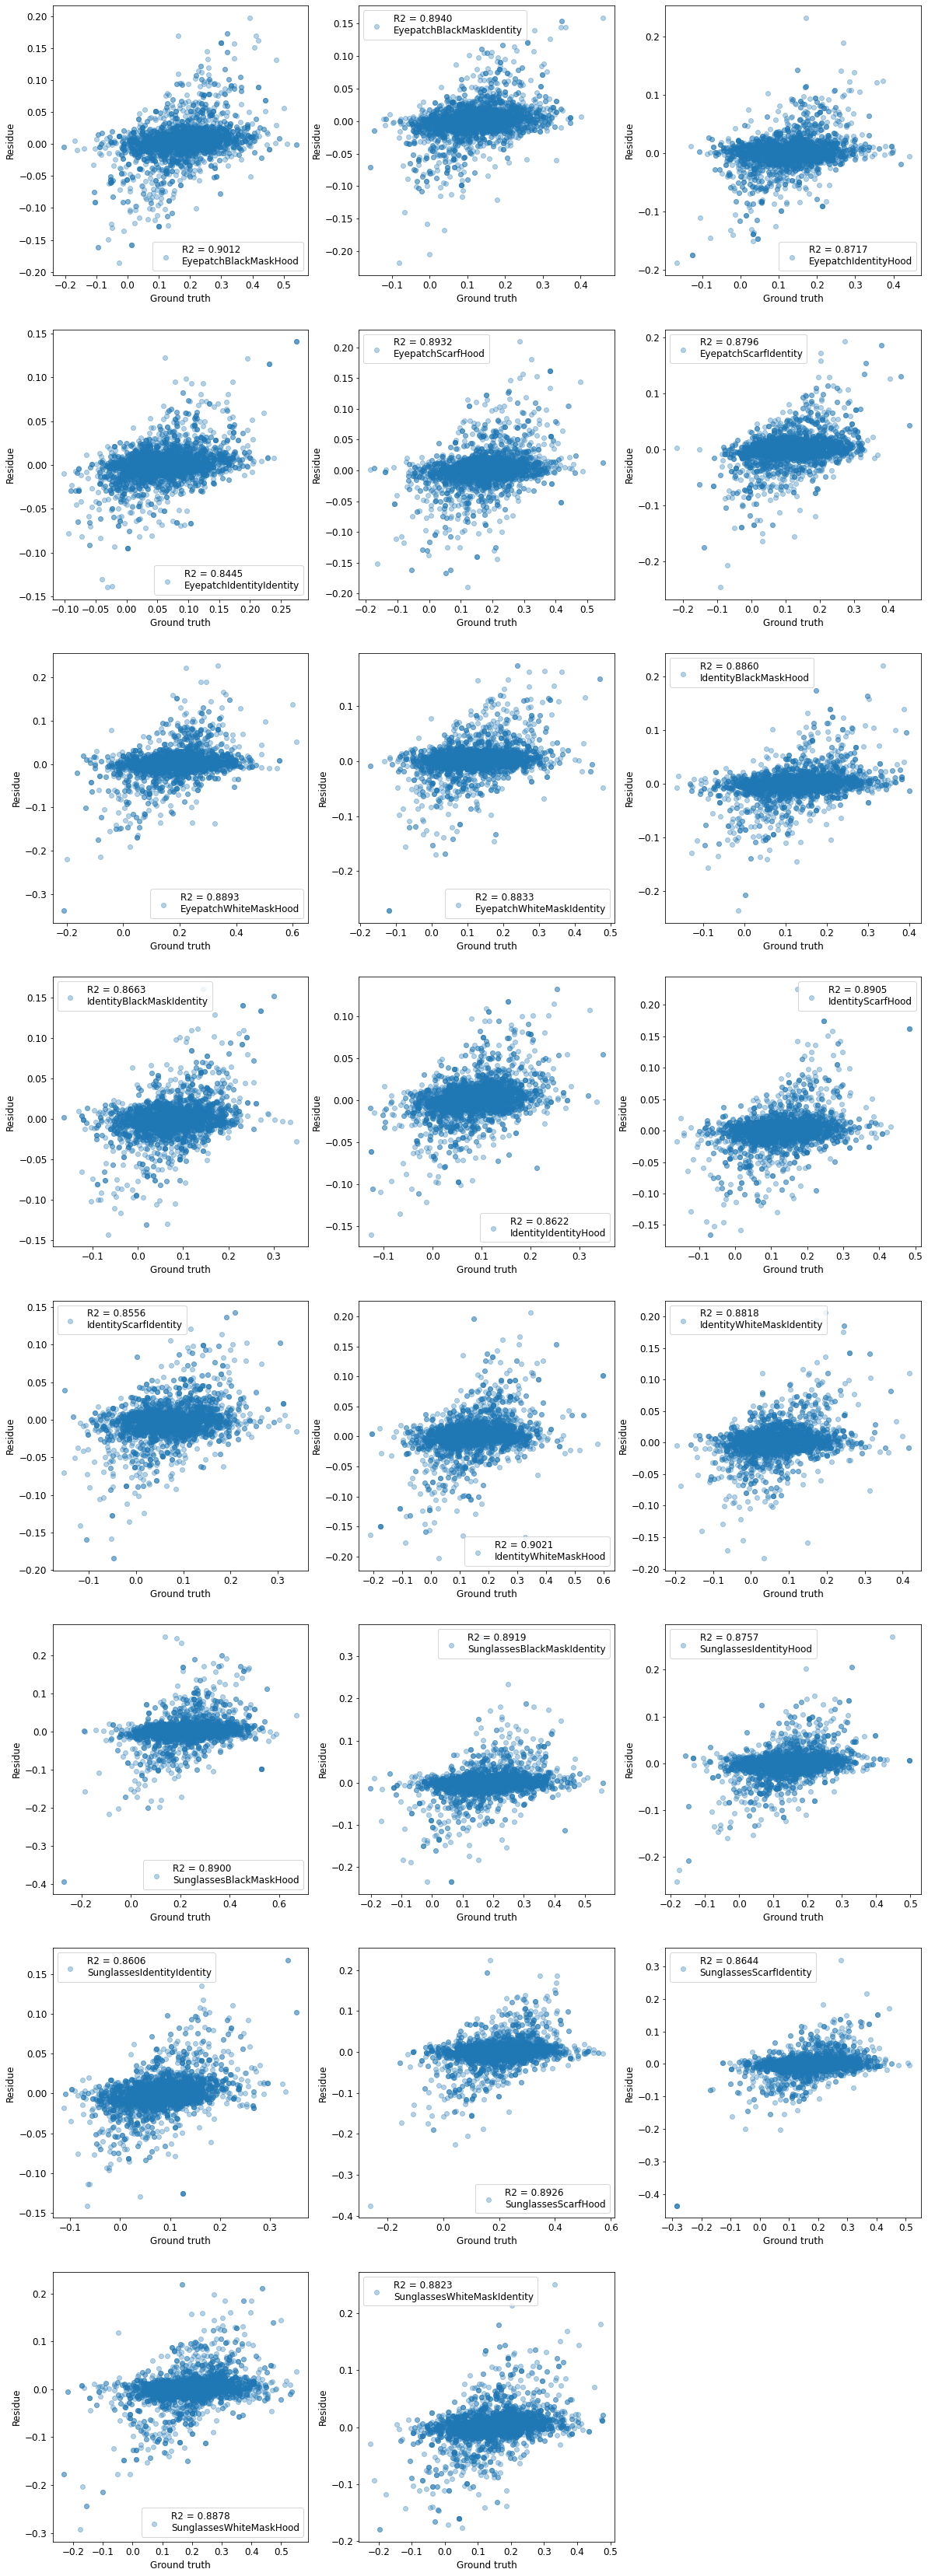

In [49]:
plt.figure(figsize=(20, 60))
idx = 0
for label in np.unique(labels):
    if label == 'IdentityIdentityIdentity':
        continue
    idx += 1
    plt.subplot(8, 3, idx)
    gt_label = np.array(gt).flatten()[labels==label]
    pred_label = np.array(pred).flatten()[labels==label]
    plt.scatter(gt_label, gt_label - pred_label, alpha=0.333, label='R2 = {:.4f}\n{}'.format(r2_score(gt_label, pred_label), label))
    plt.legend(fontsize=12)
    plt.xlabel('Ground truth', fontsize=12)
    plt.ylabel('Residue', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
plt.show()

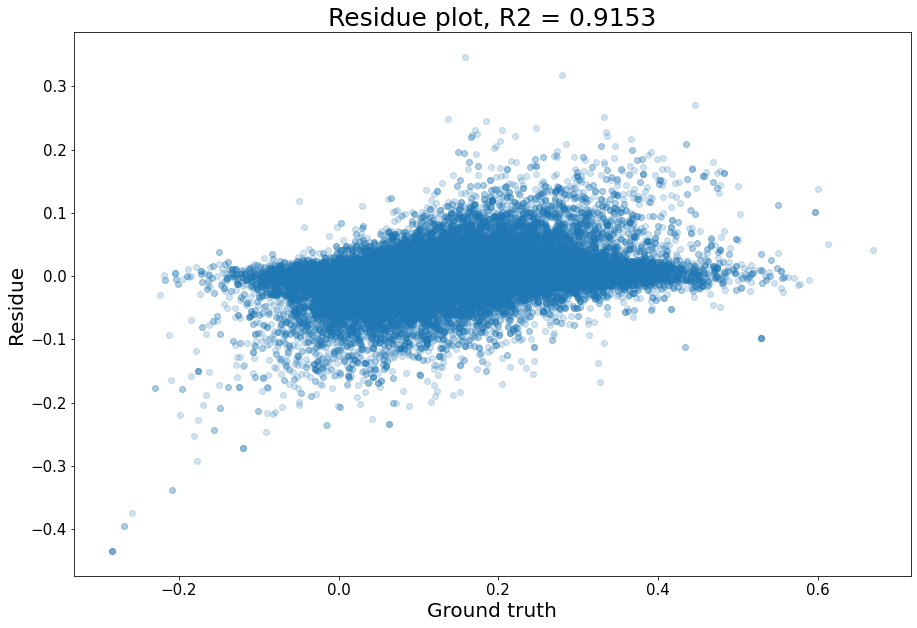

In [51]:
plt.figure(figsize=(15, 10))
plt.scatter(np.array(gt).flatten(), np.array(gt).flatten() - np.array(pred).flatten(), alpha=0.2)
plt.title('Residue plot, R2 = {:.4f}'.format(r2_score(gt, pred)), fontsize=25)
plt.xlabel('Ground truth', fontsize=20)
plt.ylabel('Residue', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(PATH+'/presentation/residue_plot.pdf', format='pdf')

Для каждого закрытия объединяем его примеры с незакрытыми, после чего по предсказаниям модели строим ROC кривую относительно бинарной метки того, что идентификация затруднена (то есть, ground truth метка превышает посчитанный выше порог). Вычисляем по кривым ROC-AUC и отмечаем наилучший threshold. После каждой кривой выводим таблицу TPR в зависимости от FPR с соответствующими threshold'ами.

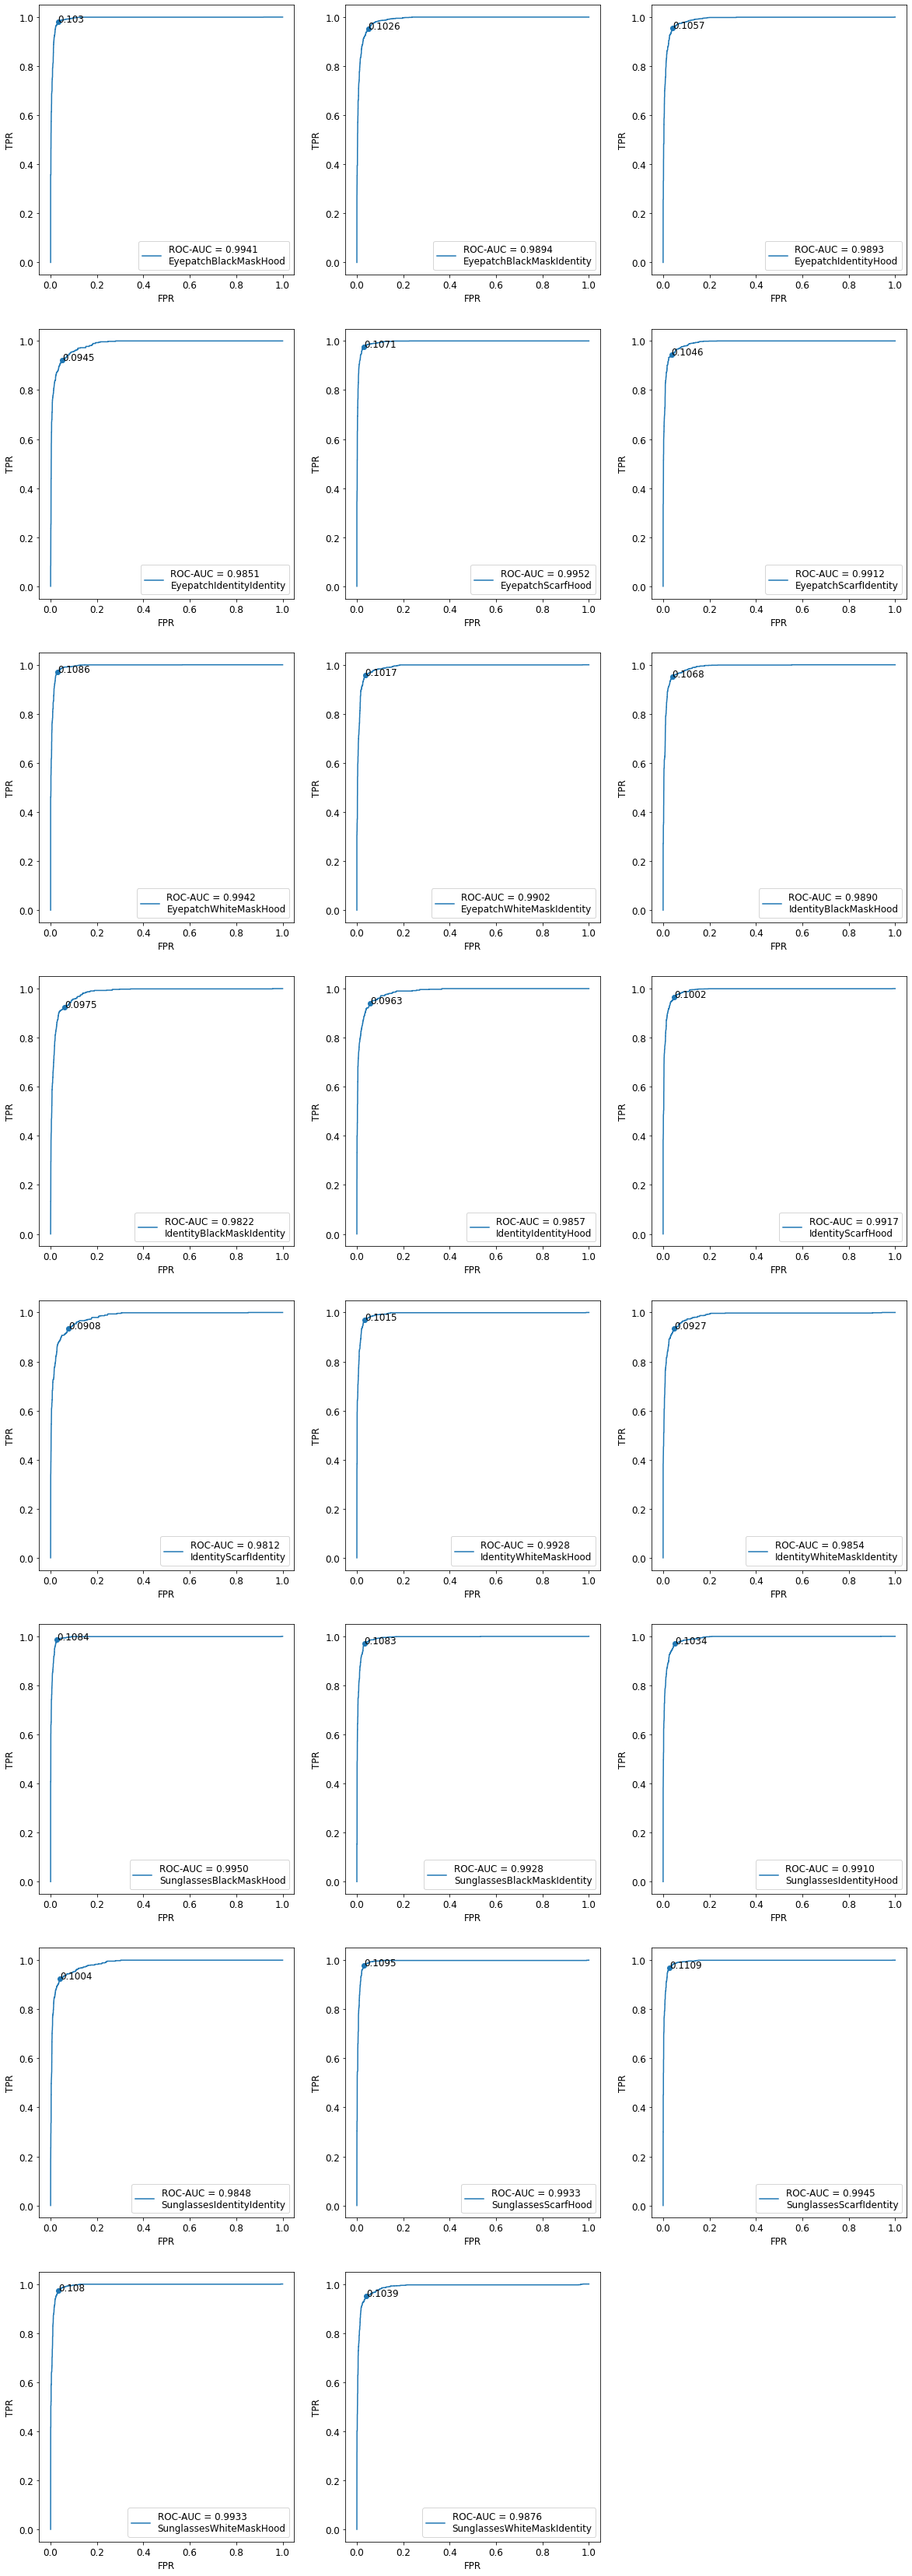

In [19]:
plt.figure(figsize=(20, 60))
idx = 0
for label in np.unique(labels):
    if label == 'IdentityIdentityIdentity':
        continue
    idx += 1
    plt.subplot(8, 3, idx)
    pred_label = np.array(pred).flatten()[labels==label]
    pred_id = np.array(pred).flatten()[labels=='IdentityIdentityIdentity']
    y_true = np.concatenate(((np.array(gt)[labels=='IdentityIdentityIdentity'] > THRESHOLD), (np.array(gt)[labels==label] > THRESHOLD)))
    y_score = np.concatenate((pred_id, pred_label))
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    best_fpr, best_tpr, best_threshold = min(zip(*roc_curve(y_true, y_score)), key = lambda triple: triple[0]**2 + (1-triple[1])**2)
    plt.plot(fpr, tpr, label='ROC-AUC = {:.4f}\n{}'.format(roc_auc_score(y_true, y_score), label))
    plt.scatter([best_fpr], [best_tpr])
    plt.annotate(np.round(best_threshold, 4), (best_fpr, best_tpr), fontsize=12)
    plt.legend(fontsize=12)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
plt.show()

In [20]:
FPRS = np.array([0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3])
FPRS

array([0.   , 0.001, 0.003, 0.01 , 0.03 , 0.1  , 0.3  ])

In [21]:
idx = 0
for label in np.unique(labels):
    if label == 'IdentityIdentityIdentity':
        continue
    idx += 1
    pred_label = np.array(pred).flatten()[labels==label]
    pred_id = np.array(pred).flatten()[labels=='IdentityIdentityIdentity']
    y_true = np.concatenate(((np.array(gt)[labels=='IdentityIdentityIdentity'] > THRESHOLD), (np.array(gt)[labels==label] > THRESHOLD)))
    y_score = np.concatenate((pred_id, pred_label))
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    tobe_df = {"fpr": [], "tpr": [], "threshold": []}
    for target_fpr in FPRS:
        valid_idx = np.where(fpr <= target_fpr)[0]
        idx = valid_idx[fpr[valid_idx].argmax()]
        tobe_df["fpr"].append(fpr[idx])
        tobe_df["tpr"].append(tpr[idx])
        tobe_df["threshold"].append(thresholds[idx])
    print(label)
    display(pd.DataFrame(tobe_df))

EyepatchBlackMaskHood


,fpr,tpr,threshold
0,0.000000,0.000000,1.540801
1,0.000000,0.000000,1.540801
2,0.002763,0.602205,0.183157
3,0.009797,0.808736,0.147316
4,0.029641,0.973707,0.105885
5,0.099975,0.997031,0.063591
6,0.299673,0.999576,0.003949


EyepatchBlackMaskIdentity


,fpr,tpr,threshold
0,0.000000,0.000000,1.395713
1,0.000865,0.316637,0.195465
2,0.002810,0.469290,0.170787
3,0.009944,0.744186,0.135434
4,0.029615,0.914132,0.111087
5,0.099654,0.985092,0.082154
6,0.299611,1.000000,0.007413


EyepatchIdentityHood


,fpr,tpr,threshold
0,0.000000,0.000000,1.445785
1,0.000898,0.257431,0.205811
2,0.002471,0.482484,0.170766
3,0.009883,0.746815,0.135575
4,0.029650,0.927813,0.111369
5,0.099955,0.981953,0.082634
6,0.299641,0.998408,0.006300


EyepatchIdentityIdentity


,fpr,tpr,threshold
0,0.000000,0.000000,1.230223
1,0.000867,0.177281,0.157208
2,0.002949,0.535284,0.128767
3,0.009714,0.771084,0.112368
4,0.029835,0.876076,0.102295
5,0.099740,0.956971,0.078654
6,0.299740,1.000000,0.026616


EyepatchScarfHood


,fpr,tpr,threshold
0,0.000000,0.000000,1.535595
1,0.000761,0.378180,0.221785
2,0.002789,0.667960,0.168955
3,0.009888,0.902975,0.129808
4,0.029665,0.975852,0.107075
5,0.099645,0.993100,0.069603
6,0.299949,1.000000,0.003933


EyepatchScarfIdentity


,fpr,tpr,threshold
0,0.000000,0.000000,1.418656
1,0.000860,0.336364,0.194237
2,0.002794,0.605682,0.155029
3,0.009673,0.822159,0.127412
4,0.029235,0.934659,0.107554
5,0.099312,0.980114,0.081552
6,0.299656,1.000000,0.007835


EyepatchWhiteMaskHood


,fpr,tpr,threshold
0,0.000000,0.000000,1.561907
1,0.000767,0.460897,0.218288
2,0.002556,0.593489,0.194277
3,0.009967,0.820167,0.151212
4,0.029900,0.969829,0.108214
5,0.099157,0.994442,0.065878
6,0.299514,0.999603,0.003672


EyepatchWhiteMaskIdentity


,fpr,tpr,threshold
0,0.000000,0.000000,1.526473
1,0.000866,0.320394,0.201588
2,0.002814,0.487833,0.172815
3,0.009959,0.738123,0.134456
4,0.029660,0.940324,0.106020
5,0.099805,0.983198,0.077079
6,0.298333,0.999421,0.006812


IdentityBlackMaskHood


,fpr,tpr,threshold
0,0.000000,0.000000,1.412265
1,0.000880,0.273187,0.208712
2,0.002862,0.482293,0.175782
3,0.009905,0.730185,0.143381
4,0.029936,0.931984,0.111391
5,0.099494,0.978640,0.085312
6,0.299802,0.998876,0.006679


IdentityBlackMaskIdentity


,fpr,tpr,threshold
0,0.000000,0.000000,1.377937
1,0.000926,0.241307,0.168244
2,0.002962,0.413066,0.146498
3,0.009998,0.638567,0.127706
4,0.029994,0.872497,0.108743
5,0.099796,0.957850,0.085677
6,0.299944,0.997893,0.020618


IdentityIdentityHood


,fpr,tpr,threshold
0,0.000000,0.000000,1.338145
1,0.000758,0.330948,0.155931
2,0.002464,0.518784,0.139305
3,0.009856,0.761181,0.117415
4,0.029947,0.882826,0.106447
5,0.099886,0.963327,0.083791
6,0.299280,0.996422,0.024471


IdentityScarfHood


,fpr,tpr,threshold
0,0.000000,0.000000,1.423900
1,0.000910,0.406780,0.189040
2,0.002959,0.573190,0.163629
3,0.009558,0.785824,0.133336
4,0.029813,0.935799,0.108927
5,0.099681,0.987673,0.077807
6,0.299499,0.999486,0.005718


IdentityScarfIdentity


,fpr,tpr,threshold
0,0.000000,0.000000,1.354369
1,0.000909,0.363095,0.152625
2,0.002726,0.545238,0.136633
3,0.009996,0.720238,0.123555
4,0.029989,0.870238,0.109838
5,0.099782,0.951190,0.083691
6,0.299709,0.996429,0.023810


IdentityWhiteMaskHood


,fpr,tpr,threshold
0,0.000000,0.000000,1.590244
1,0.000929,0.382596,0.208985
2,0.002555,0.643170,0.163358
3,0.009988,0.821099,0.133791
4,0.029733,0.959650,0.106084
5,0.099652,0.992222,0.075934
6,0.299652,0.999028,0.005088


IdentityWhiteMaskIdentity


,fpr,tpr,threshold
0,0.000000,0.000000,1.424660
1,0.000916,0.414384,0.158959
2,0.002748,0.510274,0.143942
3,0.009894,0.764840,0.118295
4,0.029681,0.892694,0.103241
5,0.098937,0.969178,0.075568
6,0.299194,0.997717,0.011989


SunglassesBlackMaskHood


,fpr,tpr,threshold
0,0.000000,0.000000,1.627141
1,0.000826,0.434622,0.262534
2,0.002753,0.700552,0.197530
3,0.009912,0.864088,0.153058
4,0.029460,0.985267,0.105872
5,0.099394,0.998895,0.024396
6,0.299284,0.998895,0.002894


SunglassesBlackMaskIdentity


,fpr,tpr,threshold
0,0.000000,0.000000,1.573197
1,0.000760,0.153146,0.296932
2,0.002786,0.620447,0.181367
3,0.009625,0.820778,0.143146
4,0.029382,0.961921,0.111363
5,0.099291,0.992964,0.071114
6,0.299899,0.998758,0.003949


SunglassesIdentityHood


,fpr,tpr,threshold
0,0.000000,0.000000,1.490993
1,0.000929,0.428967,0.191944
2,0.002323,0.547048,0.177807
3,0.009988,0.793819,0.140679
4,0.029733,0.929428,0.116139
5,0.099419,0.984779,0.085131
6,0.299884,0.999539,0.005547


SunglassesIdentityIdentity


,fpr,tpr,threshold
0,0.000000,0.000000,1.328183
1,0.000939,0.257171,0.162553
2,0.002817,0.497527,0.138374
3,0.009767,0.776459,0.118071
4,0.029865,0.896142,0.104306
5,0.099925,0.953511,0.083972
6,0.299775,0.998022,0.028928


SunglassesScarfHood


,fpr,tpr,threshold
0,0.000000,0.000000,1.574048
1,0.000528,0.304228,0.267242
2,0.002905,0.546029,0.217596
3,0.009770,0.813512,0.161997
4,0.029839,0.975109,0.111455
5,0.099287,0.996839,0.055772
6,0.298125,0.998815,0.003380


SunglassesScarfIdentity


,fpr,tpr,threshold
0,0.000000,0.000000,1.516926
1,0.000506,0.299656,0.238053
2,0.002781,0.698194,0.170251
3,0.009858,0.861565,0.137572
4,0.029323,0.969475,0.110282
5,0.099848,0.993981,0.073034
6,0.299545,0.999570,0.004002


SunglassesWhiteMaskHood


,fpr,tpr,threshold
0,0.000000,0.000000,1.541211
1,0.000773,0.415298,0.238129
2,0.002835,0.589507,0.202199
3,0.009794,0.828995,0.149989
4,0.029897,0.962755,0.112071
5,0.099742,0.995595,0.064812
6,0.299485,0.999199,0.003747


SunglassesWhiteMaskIdentity


,fpr,tpr,threshold
0,0.000000,0.000000,1.461574
1,0.000459,0.315634,0.217878
2,0.002982,0.515241,0.182205
3,0.009862,0.791052,0.139307
4,0.029587,0.927237,0.110838
5,0.100000,0.980334,0.079941
6,0.299083,0.996559,0.005304


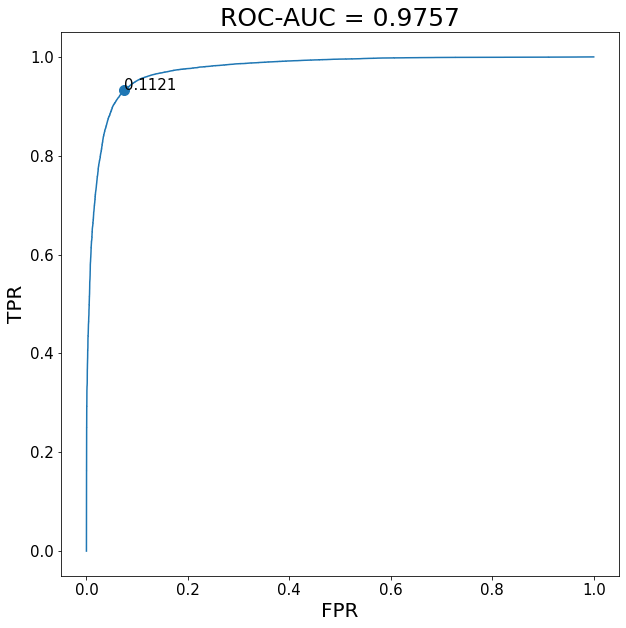

In [23]:
plt.figure(figsize=(10, 10))
pred_label = np.array(pred).flatten()[labels!='IdentityIdentityIdentity']
pred_id = np.array(pred).flatten()[labels=='IdentityIdentityIdentity']
y_true = np.concatenate(((np.array(gt)[labels=='IdentityIdentityIdentity'] > THRESHOLD), (np.array(gt)[labels!='IdentityIdentityIdentity'] > THRESHOLD)))
y_score = np.concatenate((pred_id, pred_label))
fpr, tpr, thresholds = roc_curve(y_true, y_score)
best_fpr, best_tpr, best_threshold = min(zip(*roc_curve(y_true, y_score)), key = lambda triple: triple[0]**2 + (1-triple[1])**2)
plt.plot(fpr, tpr)
plt.scatter([best_fpr], [best_tpr], s=100)
plt.annotate(np.round(best_threshold, 4), (best_fpr, best_tpr), fontsize=15)
plt.title('ROC-AUC = {:.4f}'.format(roc_auc_score(y_true, y_score)), fontsize=25)
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(PATH + '/presentation/roc_plot.pdf', format='pdf')

In [27]:
pred_label = np.array(pred).flatten()[labels!='Identity']
pred_id = np.array(pred).flatten()[labels=='Identity']
y_true = np.concatenate(((np.array(gt)[labels=='Identity'] > THRESHOLD), (np.array(gt)[labels!='Identity'] > THRESHOLD)))
y_score = np.concatenate((pred_id, pred_label))
fpr, tpr, thresholds = roc_curve(y_true, y_score)
tobe_df = {"fpr": [], "tpr": [], "threshold": []}
for target_fpr in FPRS:
    valid_idx = np.where(fpr <= target_fpr)[0]
    idx = valid_idx[fpr[valid_idx].argmax()]
    tobe_df["fpr"].append(np.round(100 * fpr[idx], 2))
    tobe_df["tpr"].append(np.round(100 * tpr[idx], 2))
    tobe_df["threshold"].append(thresholds[idx])
display(pd.DataFrame(tobe_df))

,fpr,tpr,threshold
0,0.00,0.00,1.627141
1,0.09,32.40,0.219833
2,0.30,42.67,0.198255
3,1.00,62.60,0.163227
4,2.99,81.44,0.133025
5,10.00,95.21,0.106367
6,30.00,98.62,0.079262


In [28]:
print(pd.DataFrame(tobe_df).to_latex(index=False))

\begin{tabular}{rrr}
\toprule
   fpr &    tpr &  threshold \\
\midrule
  0.00 &   0.00 &   1.627141 \\
  0.09 &  32.40 &   0.219833 \\
  0.30 &  42.67 &   0.198255 \\
  1.00 &  62.60 &   0.163227 \\
  2.99 &  81.44 &   0.133025 \\
 10.00 &  95.21 &   0.106367 \\
 30.00 &  98.62 &   0.079262 \\
\bottomrule
\end{tabular}



In [29]:
best_fpr, best_tpr, best_threshold = min(zip(*roc_curve(y_true, y_score)), key = lambda triple: triple[0]**2 + (1-triple[1])**2)
print("FPR при наилучшем threshold:", np.round(best_fpr, 4))
print("TPR при наилучшем threshold:", np.round(best_tpr, 4))
print("Наилучший threshold:", best_threshold)
print("\nМетрики бинарной классификации:")
print(classification_report(y_true, y_score > best_threshold))

FPR при наилучшем threshold: 0.0738
TPR при наилучшем threshold: 0.9324
Наилучший threshold: 0.11213493

Метрики бинарной классификации:
              precision    recall  f1-score   support

       False       0.92      0.93      0.92     33711
        True       0.94      0.93      0.94     42088

    accuracy                           0.93     75799
   macro avg       0.93      0.93      0.93     75799
weighted avg       0.93      0.93      0.93     75799



Сгенерируем набор случайных примеров работы сети: для каждой фотографии выводится бинарная метка того, что идентификация затруднена, и предсказанная моделью вероятность закрытия. Вероятность считается следующим образом: если $T$ - наилучший threshold, а $y$ - предсказание модели, то вероятность принимается равной
$$p = \sigma(y/T - 1)$$
Здесь $\sigma$ - сигмоида:
$$\sigma(x) = \dfrac{1}{1 + \exp(-x)}$$

In [30]:
def test_ds_gen_random():
    yield from tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1/255.,
        brightness_range=(1, 1),
        horizontal_flip=False,
        vertical_flip=False
    ).flow_from_dataframe(
        test_df.sample(len(test_df)), directory='.', x_col='img', y_col='label', target_size=(224, 224), 
        color_mode='rgb',
        class_mode='raw', batch_size=25, shuffle=False, seed=None,
        subset=None
    )

In [31]:
test_ds_random = tf.data.Dataset.from_generator(test_ds_gen_random, output_types=(tf.float32, tf.float32),
                                                output_shapes=((25, 224, 224, 3), (25,)))
test_ds_random = test_ds_random.map(lambda img, label: (tf.convert_to_tensor(img, tf.float32), label)).take(7)

In [32]:
data = []
gt = []
def datagt_save_gen(ds):
    global data
    global gt
    data = []
    gt = []
    for entry in ds:
        data.extend(entry[0].numpy())
        gt.extend(entry[1].numpy())
        yield entry
pred = model.predict(datagt_save_gen(test_ds_random))

Found 75799 validated image filenames.


In [33]:
plt.figure(figsize=(20, 160))
for i in range(128):
    plt.subplot(32, 4, i+1)
    plt.imshow(data[i])
    plt.axis("off")
    plt.title("Obstructed: {}\nPredicted: {:.4f}".format(gt[i] > THRESHOLD,1 / (1 + np.exp(-(np.array(pred).flatten()[i] / best_threshold - 1)))), fontsize=20)

Output hidden; open in https://colab.research.google.com to view.

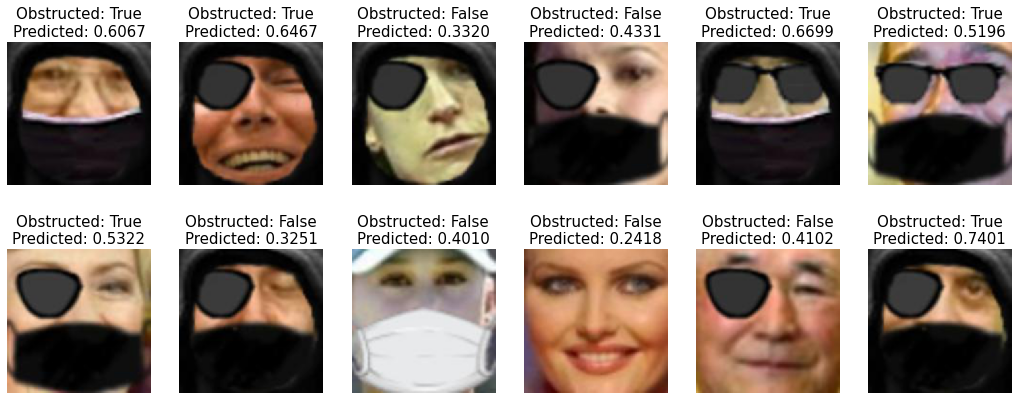

In [43]:
plt.figure(figsize=(18, 7))
for i in range(60, 72):
    plt.subplot(2, 6, i-59)
    plt.imshow(data[i])
    plt.axis("off")
    plt.title("Obstructed: {}\nPredicted: {:.4f}".format(gt[i] > THRESHOLD,1 / (1 + np.exp(-(np.array(pred).flatten()[i] / best_threshold - 1)))), fontsize=15)
plt.savefig(PATH + '/presentation/preds_demo.pdf', format='pdf')